In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Z and mag filters :

In [3]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<28','mag_i>18',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

### CosmoDC2 and DC2Objects (truth and object) :

In [4]:
import GCRCatalogs
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
cosmodc2.get_quantity_info('is_central')

In [6]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [7]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters, 
                                      native_filters=healpix_filter))

In [9]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 2920943
nombre de galaxies centrales = 2669420
pourcentage de galaxies centrales = 91.38897951791596 %
nombre d'objets = 676713


### FoF algo :

In [10]:
my_linking_length = 0.4 #linking_lenghts optimal in arcseconds , for 18<mag<26.5

In [11]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                  linking_lengths=my_linking_length)

In [12]:
# first we need to know which rows are from the truth catalog and which are from the object

truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

In [13]:
# np.bincount will give up the number of id occurrences (like histogram but with integer input)

n_groups = results['group_id'].max() + 1   #nombre de groupes total (groupe/objet)
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)  # groupe d'objets

print(results['group_id'].max())

2852652


In [14]:
print('total nbr of groups = ', n_groups)
print('nbr of group with at list 1 galaxies = ', len(n_truth[n_truth>0]), "(", (len(n_truth[n_truth>0])/n_groups)*100, '%)')
print('nbr of group with at list 1 object =', len(n_object[n_object>0]), "(", (len(n_object[n_object>0])/n_groups)*100, '%)')

total nbr of groups =  2852653
nbr of group with at list 1 galaxies =  2822154 ( 98.9308548919199 %)
nbr of group with at list 1 object = 676675 ( 23.72090121020678 %)


#### Galaxy central selection :

In [15]:
ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)

In [16]:
ind_galax_central = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)

In [17]:
n_truth_central=np.bincount(results[truth_mask][ind_galax_central]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

In [18]:
print('nbr of group with at list 1 central galaxies = ', len(n_truth_central[n_truth_central>0]), "(", (len(n_truth[n_truth_central>0])/n_groups)*100, '%)')

nbr of group with at list 1 central galaxies =  2589936 ( 90.7904326253491 %)


Normalised histogram. When we remove satellite galaxies, we can observe a small increase in unrelated object.  

### Satellite galaxies selection :

In [19]:
ind_galax_sat = ~ind_galax_central  #donne indices des galaxies satellites dans l'ordre de results (par groupe_id)

# Halo_mass + z max cut :

In [20]:
truth_data_halo_mass= truth_data['halo_mass'][ind_galax]

truth_data_z= truth_data['redshift'][ind_galax]

In [21]:
halo_mass_cut_13=np.array([1e13, 5*1e13, 1e14])

z_max_cut= 1.5

## Halo_mass >1e13 + z-max-cut study for all galaxies :

In [22]:
n_truth_2cut_all = np.bincount(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]['group_id'],
                               minlength=n_groups)

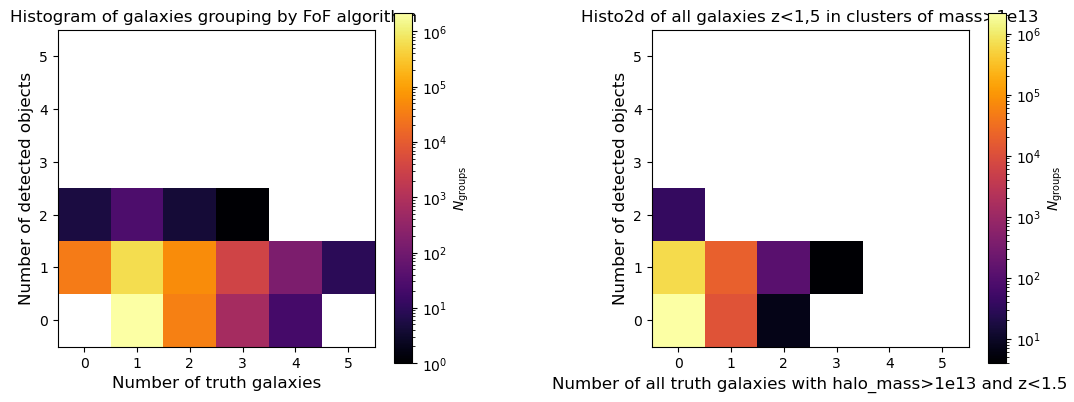

In [23]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_all=plt.hist2d(n_truth_2cut_all, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all truth galaxies with halo_mass>1e13 and z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histo2d of all galaxies z<1,5 in clusters of mass>1e13')

plt.savefig('FoF histo2d plot/Histo2d of all galaxies z<1,5 in clusters of mass>1e13')
plt.show()

In [24]:
print("missed detections :")

print("nbr of (1-0) systems for all truth galaxies with z>1,5 and halo_mass>1e13=", hist2d2_2cut_all[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_all[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_all[0][2,1])

missed detections :
nbr of (1-0) systems for all truth galaxies with z>1,5 and halo_mass>1e13= 12003.0
recognized blending :
nbr of (1-1) systems = 19615.0
unrecognized blending :
nbr of (2-1) systems = 116.0


In [25]:
print("% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,0]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]))*100)

print("% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]))*100)

print("% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][2,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]))*100)

% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 37.65528924582758
% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 61.535324381980175
% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 0.3639101518383737


## Halo_mass >1e13 + z-max-cut study for central galaxies :

In [26]:
n_truth_2cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]]['group_id'],
                               minlength=n_groups)

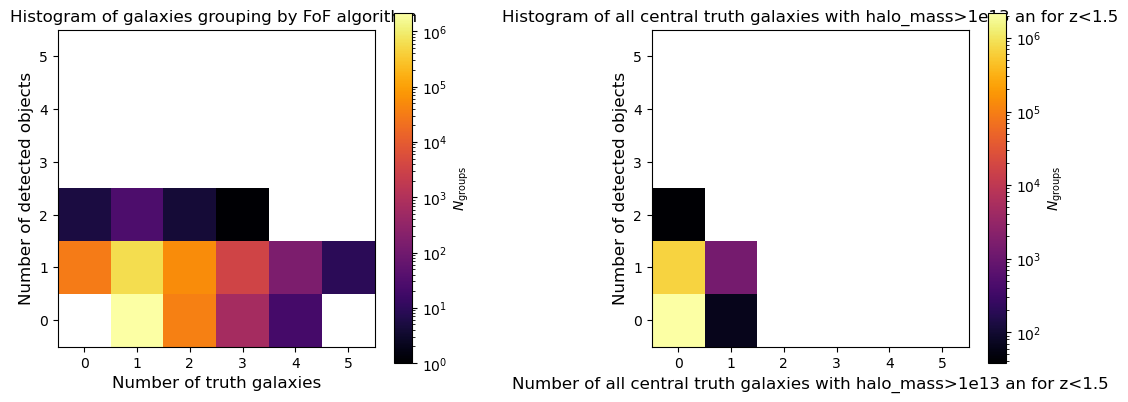

In [27]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_central=plt.hist2d(n_truth_2cut_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all central truth galaxies with halo_mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all central truth galaxies with halo_mass>1e13 an for z<1.5')

plt.show()

In [28]:
print("missed detections :")

print("nbr of (1-0) systems for all central truth galaxies with z>1,5 and halo_mass >1e13 =", hist2d2_2cut_central[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_central[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_central[0][2,1])

missed detections :
nbr of (1-0) systems for all central truth galaxies with z>1,5 and halo_mass >1e13 = 65.0
recognized blending :
nbr of (1-1) systems = 1349.0
unrecognized blending :
nbr of (2-1) systems = 0.0


In [29]:
print("% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,0]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]]))*100)

print("% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]]))*100)

print("% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][2,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]]))*100)

% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 4.596888260254596
% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 95.40311173974541
% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 0.0


## Halo_mass >1e13 + z-max-cut study for sat galaxies :

In [30]:
n_truth_2cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13[0]))[0]]['group_id'],
                               minlength=n_groups)

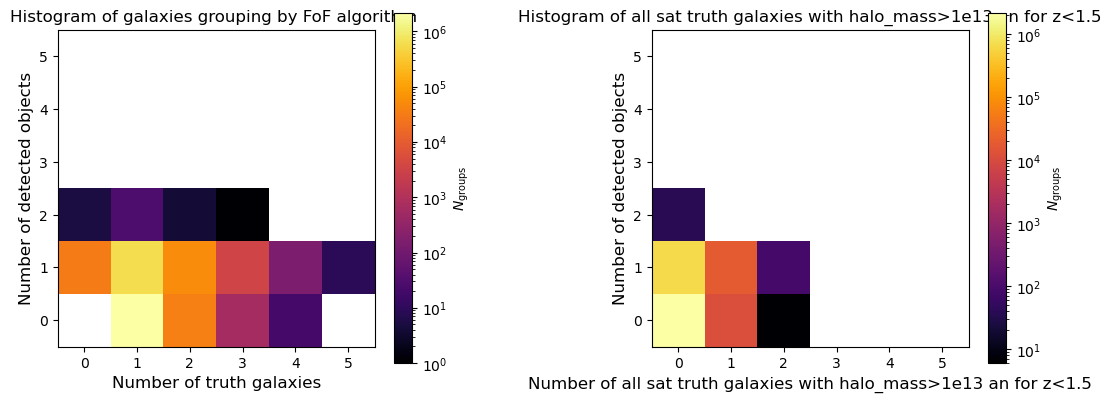

In [31]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_sat=plt.hist2d(n_truth_2cut_sat, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all sat truth galaxies with halo_mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all sat truth galaxies with halo_mass>1e13 an for z<1.5')

plt.show()

In [32]:
print("missed detections :")

print("nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 =", hist2d2_2cut_sat[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_sat[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_sat[0][2,1])

missed detections :
nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 = 11940.0
recognized blending :
nbr of (1-1) systems = 18336.0
unrecognized blending :
nbr of (2-1) systems = 87.0


In [33]:
print("% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,0]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13[0]))[0]]))*100)

print("% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13[0]))[0]]))*100)

print("% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][2,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13[0]))[0]]))*100)

% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 39.19637581248769
% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 60.19302737837305
% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 0.2856017333070711


# (1-0) system study for galaxy in clusters :

In [34]:
##### cut et différents objets utiles :

# galaxy central selection :

ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)
ind_galax_central = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)
n_truth_central=np.bincount(results[truth_mask][ind_galax_central]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

####################################################################################

truth_data_halo_mass= truth_data['halo_mass'][ind_galax]
truth_data_z= truth_data['redshift'][ind_galax]
truth_data_i_mag= truth_data['mag_i'][ind_galax]

#cut :

halo_mass_cut_13=np.array([1e13, 5*1e13, 1e14])
z_max_cut= 1.5

In [35]:
#selection indice des galaxies présentes dans les systèmes 1-0 :

system_1_0_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 0)))
system_1_0_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 1) & (n_object == 0)))
system_1_0_mask_sat= np.in1d(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13[0]))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_sat == 1) & (n_object == 0)))

ind_truth_all_1_0=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]][system_1_0_mask_all]['row_index']
ind_truth_central_1_0=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]][system_1_0_mask_central]['row_index']
ind_truth_sat_1_0=results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13[0]))[0]][system_1_0_mask_sat]['row_index']

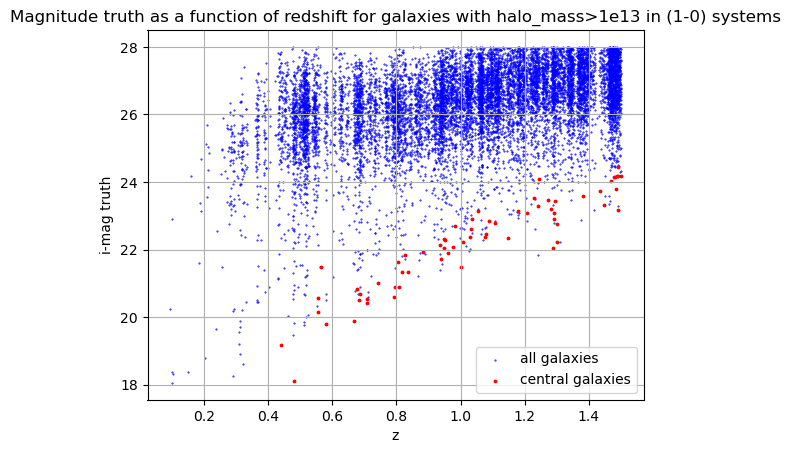

In [36]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_1_0], truth_data['mag_i'][ind_truth_all_1_0], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_1_0], truth_data['mag_i'][ind_truth_central_1_0], s=3, label='central galaxies', color='red')
plt.xlabel('z')
plt.ylabel('i-mag truth')
plt.title('Magnitude truth as a function of redshift for galaxies with halo_mass>1e13 in (1-0) systems')
plt.legend()
plt.grid()
plt.savefig('(1-0)_system_study_for_galaxy_in_clusters_plot/Magnitude truth as a function of redshift for galaxies with halo_mass>1e13 in (1-0) systems')
plt.show()

In [37]:
print("% of missed detection in clusters with a mass >1e13 and at z<1,5 =", (len(ind_truth_all_1_0)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]))*100)

% of missed detection in clusters with a mass >1e13 and at z<1,5 = 37.65528924582758


In [38]:
#Coordinates of the truth and detected objects :

truth_sc_1_0_all = SkyCoord(truth_data['ra'][ind_truth_all_1_0], truth_data['dec'][ind_truth_all_1_0], unit="deg")

ra_truth_1_0_all = truth_sc_1_0_all.ra
dec_truth_1_0_all = truth_sc_1_0_all.dec

#########

truth_sc_1_0_central = SkyCoord(truth_data['ra'][ind_truth_central_1_0], truth_data['dec'][ind_truth_central_1_0], unit="deg")


ra_truth_1_0_central = truth_sc_1_0_central.ra
dec_truth_1_0_central = truth_sc_1_0_central.dec

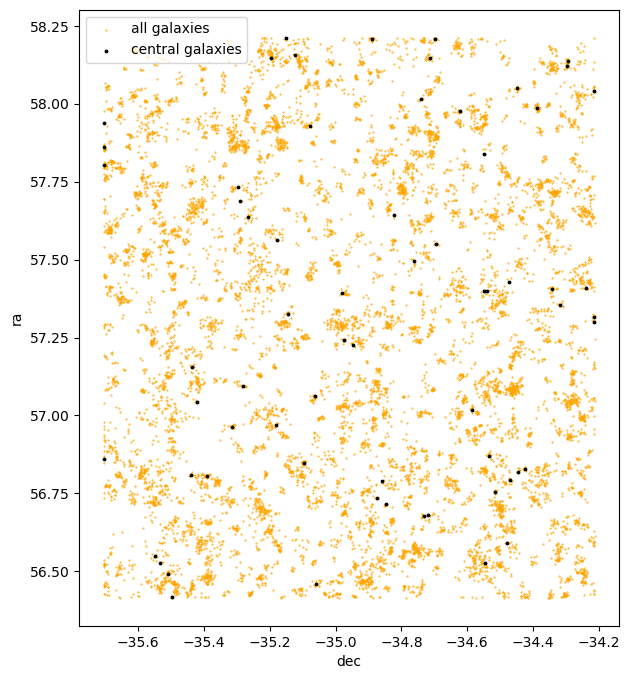

In [39]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
plt.scatter(dec_truth_1_0_all, ra_truth_1_0_all, s=0.2, label='all galaxies', color='orange')
plt.scatter(dec_truth_1_0_central, ra_truth_1_0_central, s=3, label='central galaxies', color='black')
plt.legend()
plt.xlabel('dec')
plt.ylabel('ra')

plt.show()

We cannot say anything with just the plot of ra, dec coordonate.

#### Fraction below i-mag = 24 (mag lim) :

In [40]:
n_truth_3cut_all = np.bincount(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0])  & (truth_data_i_mag < 24))[0]]['group_id'],
                               minlength=n_groups)

n_truth_3cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0])  & (truth_data_i_mag[ind_galax_central] < 24))[0]]['group_id'],
                               minlength=n_groups)

n_truth_3cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13[0])  & (truth_data_i_mag[ind_galax_sat] < 24))[0]]['group_id'],
                               minlength=n_groups)

In [41]:
#selection indice des galaxies présentes dans les systèmes 1-0 :

system_1_0_mask_all_i_mag_24= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]) & (truth_data_i_mag < 24))[0]]['group_id'],
                             np.flatnonzero((n_truth_3cut_all == 1) & (n_object == 0)))

system_1_0_mask_central_i_mag_24= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]) & (truth_data_i_mag[ind_galax_central] < 24))[0]]['group_id'],
                                 np.flatnonzero((n_truth_3cut_central == 1) & (n_object == 0)))

system_1_0_mask_sat_i_mag_24= np.in1d(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13[0]) & (truth_data_i_mag[ind_galax_sat] < 24))[0]]['group_id'],
                                 np.flatnonzero((n_truth_3cut_sat == 1) & (n_object == 0)))

ind_truth_all_1_0_i_mag_24=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]) & (truth_data_i_mag < 24))[0]][system_1_0_mask_all_i_mag_24]['row_index']

ind_truth_central_1_0_i_mag_24=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]) & (truth_data_i_mag[ind_galax_central] < 24))[0]][system_1_0_mask_central_i_mag_24]['row_index']

ind_truth_sat_1_0_i_mag_24=results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13[0]) & (truth_data_i_mag[ind_galax_sat] < 24))[0]][system_1_0_mask_sat_i_mag_24]['row_index']

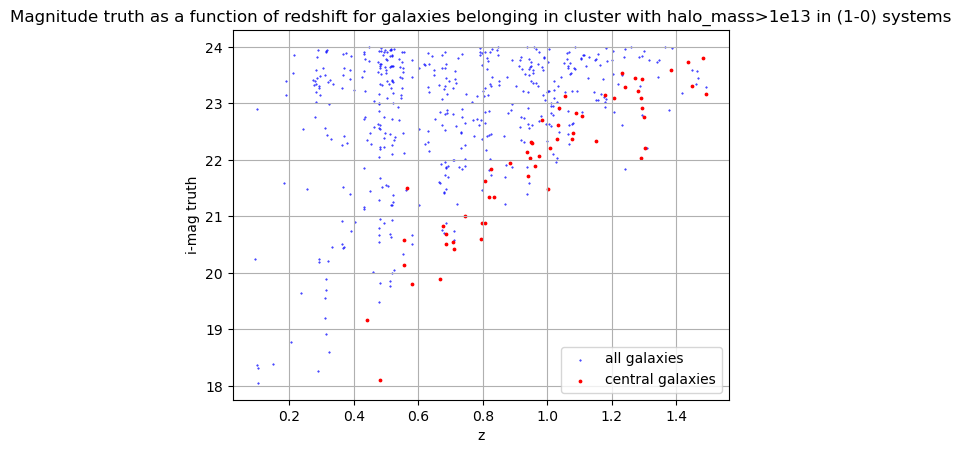

In [42]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_1_0_i_mag_24], truth_data['mag_i'][ind_truth_all_1_0_i_mag_24], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_1_0_i_mag_24], truth_data['mag_i'][ind_truth_central_1_0_i_mag_24], s=3, label='central galaxies', color='red')
plt.xlabel('z')
plt.ylabel('i-mag truth')
plt.title('Magnitude truth as a function of redshift for galaxies belonging in cluster with halo_mass>1e13 in (1-0) systems')
plt.legend()
plt.grid()
plt.savefig('(1-0)_system_study_for_galaxy_in_clusters_plot/Magnitude truth as a function of redshift for galaxies with halo_mass>1e13 in (1-0) systems with i-mag < 24')
plt.show()

In [43]:
print("% of missed detection in cluster with a mass >1e13, z<1,5 and i-mag limit = 24 is : ", (len(ind_truth_all_1_0_i_mag_24)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]) & (truth_data_i_mag < 24))[0]]))*100)

% of missed detection in cluster with a mass >1e13, z<1,5 and i-mag limit = 24 is :  4.748628473783613


In [44]:
#Coordinates of the truth and detected objects :

truth_sc_1_0_all_i_mag_24 = SkyCoord(truth_data['ra'][ind_truth_all_1_0_i_mag_24], truth_data['dec'][ind_truth_all_1_0_i_mag_24], unit="deg")

ra_truth_1_0_all_i_mag_24 = truth_sc_1_0_all_i_mag_24.ra
dec_truth_1_0_all_i_mag_24 = truth_sc_1_0_all_i_mag_24.dec

#########

truth_sc_1_0_central_i_mag_24 = SkyCoord(truth_data['ra'][ind_truth_central_1_0_i_mag_24], truth_data['dec'][ind_truth_central_1_0_i_mag_24], unit="deg")


ra_truth_1_0_central_i_mag_24 = truth_sc_1_0_central_i_mag_24.ra
dec_truth_1_0_central_i_mag_24 = truth_sc_1_0_central_i_mag_24.dec

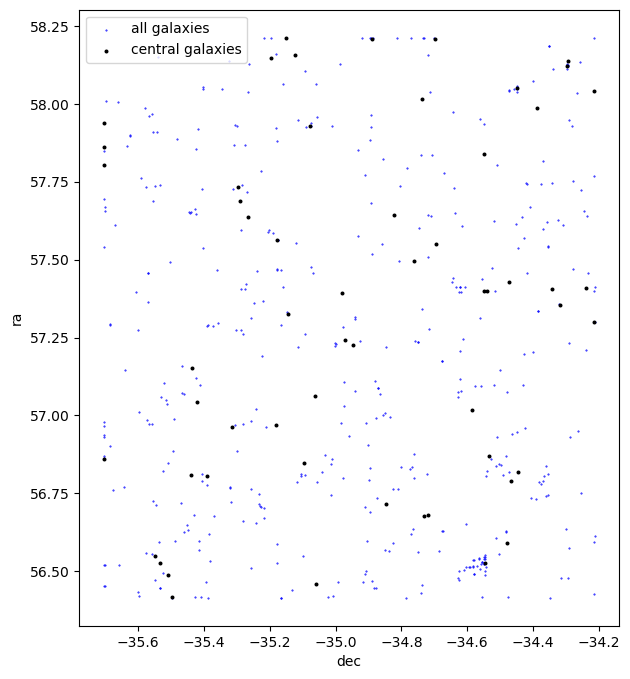

In [45]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
plt.scatter(dec_truth_1_0_all_i_mag_24, ra_truth_1_0_all_i_mag_24, s=0.2, label='all galaxies', color='blue')
plt.scatter(dec_truth_1_0_central_i_mag_24, ra_truth_1_0_central_i_mag_24, s=3.5, label='central galaxies', color='black')
plt.legend()
plt.xlabel('dec')
plt.ylabel('ra')

plt.show()

## (1-1) systems for galaxy in clusters :

In [46]:
#selection indice des galaxies présentes dans les systèmes 1-1 :

system_1_1_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 1)))
system_1_1_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 1) & (n_object == 1)))

ind_truth_all_1_1=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]][system_1_1_mask_all]['row_index']
ind_truth_central_1_1=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]][system_1_1_mask_central]['row_index']

In [47]:
[np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]

[array([    161,     565,     587, ..., 2351977, 2351978, 2351979])]

In [48]:
len(system_1_1_mask_all)

31876

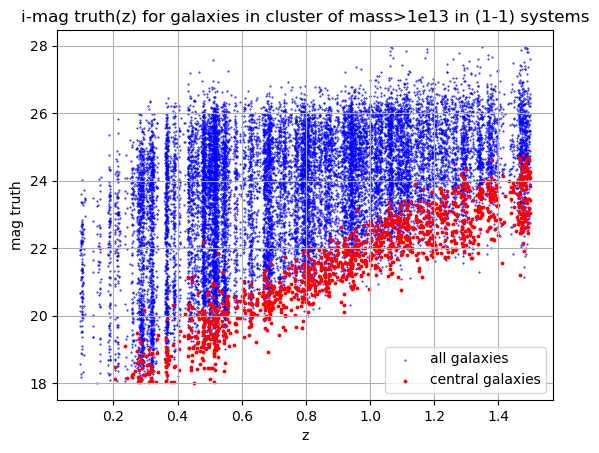

In [49]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_1_1], truth_data['mag_i'][ind_truth_all_1_1], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_1_1], truth_data['mag_i'][ind_truth_central_1_1], s=3, label='central galaxies', color='red')
plt.xlabel('z')
plt.ylabel('mag truth')
plt.title('i-mag truth(z) for galaxies in cluster of mass>1e13 in (1-1) systems')
plt.legend()
plt.grid()
plt.savefig('(1-1)_system_study_for_galaxy_in_clusters_plot/Magnitude truth as a function of redshift for galaxies belonging with mass>1e13 in (1-1) systems')
plt.show()

In [50]:
print("% of (1-1) systems in the different clusters =", (len(ind_truth_all_1_1)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]))*100)

% of (1-1) systems in the different clusters = 61.535324381980175


In [51]:
system_1_1_mask_all_obj= np.in1d(results[object_mask]['group_id'], np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 1)))

ind_object_1_1=results[object_mask][system_1_1_mask_all_obj]['row_index']

In [57]:
truth_i_mag=truth_data['mag_i'][ind_truth_all_1_1]

object_i_mag=object_data['mag_i_cModel'][ind_object_1_1]

In [159]:
def moving_average(tab, n) :
    ret = np.cumsum(tab, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_truth_i_mag= moving_average(truth_i_mag, n=10)
moving_average_object_i_mag= moving_average(object_i_mag, n=10)

In [184]:
def move_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

moving_average_truth_i_mag1= move_average(truth_i_mag, w=10)
moving_average_object_i_mag1= move_average(object_i_mag, w=10)

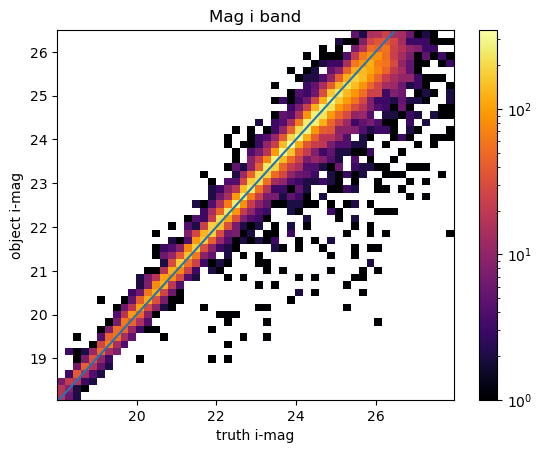

In [199]:
plt.title("Mag i band")
hist2d_mag=plt.hist2d(truth_i_mag, object_i_mag, bins=50, norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("truth i-mag")
plt.ylabel("object i-mag")
plt.savefig('(1-1)_system_study_for_galaxy_in_clusters_plot/Mag i band galaxies in clusters')
plt.show()

In [191]:
print(truth_i_mag)
print(object_i_mag)

[22.49793885 22.91217814 26.26148767 ... 22.96474611 25.08725285
 25.89867653]
[22.5736563  23.04537371 25.68457232 ... 22.97984874 24.87357548
 26.29874016]


In [188]:
print(np.std(truth_i_mag))
print(np.std(object_i_mag))

1.884344559381063
1.7815421698951013


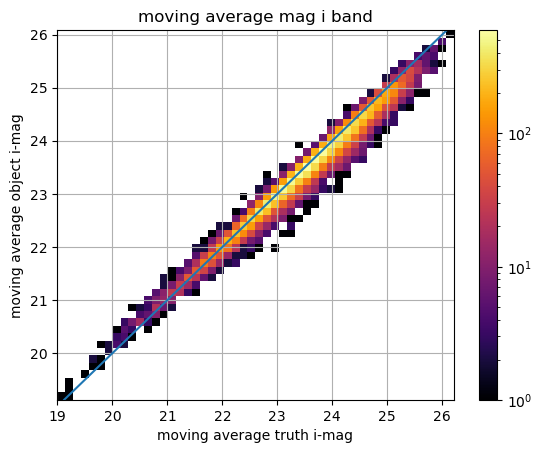

In [200]:
plt.figure()
plt.hist2d(moving_average_truth_i_mag, moving_average_object_i_mag, bins=50, norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.title("moving average mag i band")
plt.xlabel("moving average truth i-mag")
plt.ylabel("moving average object i-mag")
plt.grid()
plt.savefig('(1-1)_system_study_for_galaxy_in_clusters_plot/moving average mag i band galaxies in clusters')
plt.show()

# Faire fit linéaire sur la moyenne glissante

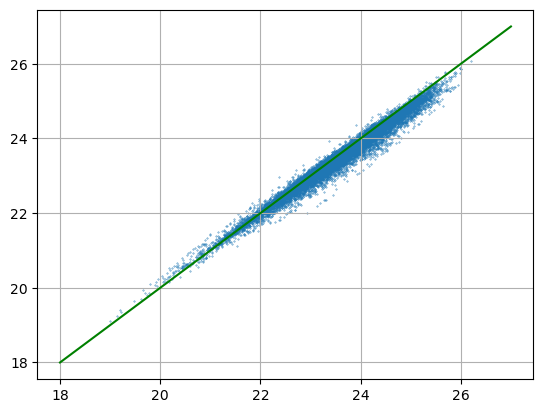

In [196]:
x=np.arange(18, 28, 1)

plt.figure()
plt.scatter(moving_average_truth_i_mag, moving_average_object_i_mag, s=0.1)
plt.plot(x, x, color='green')
plt.grid()
plt.show()

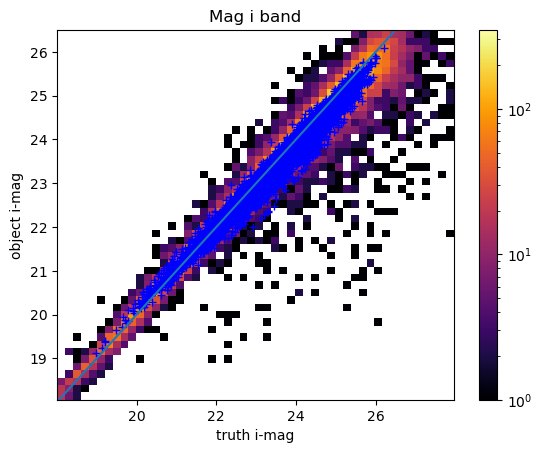

In [197]:
plt.title("Mag i band")
hist2d_mag=plt.hist2d(truth_i_mag, object_i_mag, bins=50, norm=mpl.colors.LogNorm(), cmap='inferno');
plt.plot(moving_average_truth_i_mag, moving_average_object_i_mag, '+', color='blue')
plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("truth i-mag")
plt.ylabel("object i-mag")
#plt.savefig('(1-1)_system_study_for_galaxy_in_clusters_plot/Mag i band galaxies in clusters')
plt.show()

Majority of the i-mag detected coincide with the i-mg from the truth galaxies.

There is some outliers that affect especially galaxies that are fainter : when the apparent mag is low there is a little bit of deviation, but the more the i-mag increase, the more it increase with it.



## (2-1) systems for galaxy in clusters :

In [54]:
#selection indice des galaxies présentes dans les systèmes 2-1 :

system_2_1_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 2) & (n_object == 1)))
system_2_1_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 2) & (n_object == 1)))

ind_truth_all_2_1=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]][system_2_1_mask_all]['row_index']
ind_truth_central_2_1=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13[0]))[0]][system_2_1_mask_central]['row_index']

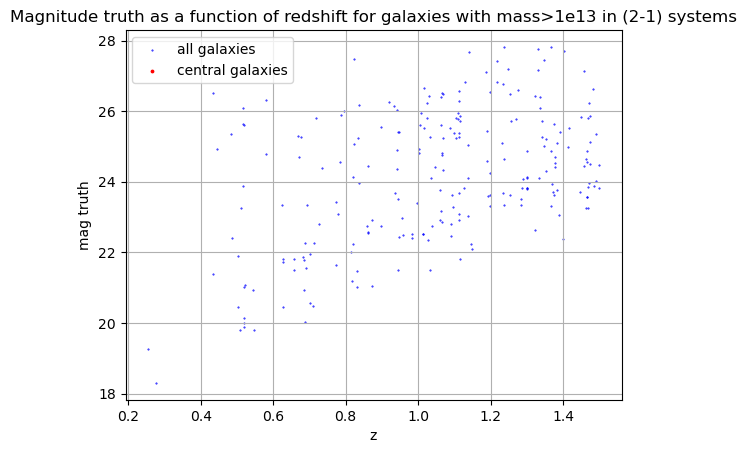

In [55]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_2_1], truth_data['mag_i'][ind_truth_all_2_1], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_2_1], truth_data['mag_i'][ind_truth_central_2_1], s=3, label='central galaxies', color='red')
plt.xlabel('z')
plt.ylabel('mag truth')
plt.title('Magnitude truth as a function of redshift for galaxies with mass>1e13 in (2-1) systems')
plt.legend()
plt.grid()
plt.savefig('(2-1)_system_study_for_galaxy_in_clusters_plot/Magnitude truth as a function of redshift for galaxies with mass>1e13 in (2-1) systems')
plt.show()

In [56]:
print("% of (2-1) systems in the different clusters =", (len(ind_truth_all_2_1)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]))[0]]))*100)

print("petit pourcentage mais normal puisque l'on selectionne que les galaxies appartenants aux clusters en ne prenant pas en compte des galaxies en background avec lesquelles il y a une           probabilité plus forte d'y avoir blending. (cf notebook study_with_background_galaxies)")

% of (2-1) systems in the different clusters = 0.7278203036767474
petit pourcentage mais normal puisque l'on selectionne que les galaxies appartenants aux clusters en ne prenant pas en compte des galaxies en background avec lesquelles il y a une           probabilité plus forte d'y avoir blending. (cf notebook study_with_background_galaxies)
